# Sobre Dataset


## Contexto

A BL é uma pequena empresa de produtos de couro que recentemente começou a vender seus produtos na Amazon. Atualmente, possui cerca de 40 SKUs registrados no Mercado Indiano. Nos últimos meses, sofreu algumas perdas devido às ordens de devolução. Agora, BL procura ajuda para prever a probabilidade de uma nova ordem ser rejeitada. Isso os ajudaria a tomar as ações necessárias e, posteriormente, reduzir a perda.

## Objetivo

Para construir um modelo que predize o status da ordem ( Delivered to buyer ou Returned to seller)

## Dicionário de Dados

Os dados do Pedido são fornecidos em um arquivo excel. As colunas são:

    order_no - Número único da ordem da Amazon
    order_date - Data em que o pedido foi colocado
    buyer - Nome do comprador
    ship_city - Cidade do Endereço de Entrega
    ship_state - Estado do endereço de entrega
    sku - Unique identificador de um produto
    description - Descrição do produto
    quantity - Número de unidades encomendadas
    item_total - Valor total pago pelo comprador
    shipping_fee - Cargas suportadas pelo Boss Leathers para enviar o item
    cod - Modo de pagamento: Dinheiro na entrega ou não

### Label / Recurso de destino:

    order_status - Status da ordem

# Pipeline do Projeto

1. Importação das Bibliotecas;
0. Entendimento dos dados;
0. Tratamento dos dados (dados faltantes, coversão de valores, e criação das características de tempo)
0. Entendimento dos dados após tratamentos;
0. Visualizar insights do negócio;
0. Resumo dos insights;
0. Visualizando correlação dos dados;
0. Treinando modelos;
0. Avaliando modelos;
0. Resumo dos modelos

# 1. Importação das Bibliotecas

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    
    f1_score,
    log_loss,
    recall_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
    brier_score_loss,
    roc_curve,
    auc
)

# 2. Entendimento dos dados

In [2]:
# Importação do dataframe
df = pd.read_excel('../Data/orders_data.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   order_no      171 non-null    object
 1   order_date    171 non-null    object
 2   buyer         171 non-null    object
 3   ship_city     171 non-null    object
 4   ship_state    171 non-null    object
 5   sku           171 non-null    object
 6   description   171 non-null    object
 7   quantity      171 non-null    int64 
 8   item_total    153 non-null    object
 9   shipping_fee  145 non-null    object
 10  cod           47 non-null     object
 11  order_status  171 non-null    object
dtypes: int64(1), object(11)
memory usage: 16.2+ KB


In [4]:
df.isnull().sum()

order_no          0
order_date        0
buyer             0
ship_city         0
ship_state        0
sku               0
description       0
quantity          0
item_total       18
shipping_fee     26
cod             124
order_status      0
dtype: int64

In [5]:
df.sample(n=5, random_state= 2)

,order_no,order_date,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status
12,402-5321389-8685152,"Sat, 16 Oct, 2021, 10:11 am IST",Blessan,"COONOOR,",TAMIL NADU,SKU: 94-TSV3-EIW6,Bright and Colorful Shantiniketan Leather Elep...,1,₹449.00,₹84.96,Cash On Delivery,Delivered to buyer
23,406-9975868-3000368,"Wed, 20 Oct, 2021, 10:15 pm IST",Hema,"BENGALURU,",KARNATAKA,SKU: AY-Z7BT-BMVM,Women's Pure Leather Jhallar Clutch Purse with...,1,₹399.00,₹84.96,NaN,Delivered to buyer
42,407-7181943-1725128,"Mon, 4 Oct, 2021, 1:10 am IST",Rohan,"GURUGRAM,",HARYANA,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,₹449.00,₹84.96,NaN,Delivered to buyer
25,402-2054361-4513137,"Mon, 6 Sept, 2021, 12:46 pm IST",Ramesh,"JALESWAR,",ODISHA,SKU: TQ-OE6K-9DIK,Ultra Slim 100% Pure Leather Men's Wallet with...,1,₹649.00,₹60.18,Cash On Delivery,Delivered to buyer
100,407-9473791-2643568,"Fri, 25 Feb, 2022, 12:04 am IST",chandrima,"KATWA,",WEST BENGAL,SKU: P1-LF2X-L3ZC,Colourful and Bright Peacock Shaped Piggy Coin...,1,₹449.00,₹60.18,NaN,Delivered to buyer


# 3. Tratamento dos dados

In [6]:
def dataclean(df):
    df = df.copy()
    
    # Tratamento da coluna de data e criação de caractericas de tempo
    df['Year'] = pd.DatetimeIndex(df['order_date']).year
    df['Month'] = pd.DatetimeIndex(df['order_date']).month
    df['Date'] = pd.DatetimeIndex(df['order_date']).date
    df['Time'] = pd.DatetimeIndex(df['order_date']).time
    df['Month_Name'] = pd.DatetimeIndex(df['Date']).month_name()
    df['Day_Name'] = pd.DatetimeIndex(df['order_date']).day_name()

    df.drop(columns= 'order_date', inplace= True)
    
    # Tratando as colunas "Ship_city" e "Ship_state"
    for label in ['ship_city', 'ship_state']: 
        df[label] = df[label].str.replace(',', '', regex= False)
        df[label] = df[label].str.upper()
        
    # Tratando dados faltantes
    df['item_total'].fillna('0', inplace= True)
    df['shipping_fee'].fillna('0', inplace= True)
    df['cod'].fillna('Online', inplace= True)
    
    # Removendo simbolos nas colunas "item_total", "shipping_fee" e convertendo valores
    for label in ['item_total', 'shipping_fee']:
        df[label] = df[label].str.replace('₹', '')
        df[label] = df[label].str.replace(',', '')
        df[label] = df[label].astype(np.float64)
        
    # Removendo o "SKU:" da coluana "sku"
    df['sku'] = df['sku'].str.replace('SKU: ', '', regex= False)
    
    return df

In [7]:
df = dataclean(df)

# 4. Entendimento dos dados após tratamentos

In [8]:
df.head()

,order_no,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status,Year,Month,Date,Time,Month_Name,Day_Name
0,405-9763961-5211537,Mr.,CHANDIGARH,CHANDIGARH,2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,449.0,0.00,Online,Delivered to buyer,2021,7,2021-07-18,22:38:00,July,Sunday
1,404-3964908-7850720,Minam,PASIGHAT,ARUNACHAL PRADESH,DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,Online,Delivered to buyer,2021,10,2021-10-19,18:05:00,October,Tuesday
2,171-8103182-4289117,yatipertin,PASIGHAT,ARUNACHAL PRADESH,DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,Online,Delivered to buyer,2021,11,2021-11-28,22:20:00,November,Sunday
3,405-3171677-9557154,aciya,DEVARAKONDA,TELANGANA,AH-J3AO-R7DN,Pure 100% Leather Block Print Rectangular Jewe...,1,0.0,0.00,Cash On Delivery,Delivered to buyer,2021,7,2021-07-28,04:06:00,July,Wednesday
4,402-8910771-1215552,Susmita,MUMBAI,MAHARASHTRA,KL-7WAA-Z82I,Pure Leather Sling Bag with Multiple Pockets a...,1,1099.0,84.96,Online,Delivered to buyer,2021,9,2021-09-28,14:50:00,September,Tuesday


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_no      171 non-null    object 
 1   buyer         171 non-null    object 
 2   ship_city     171 non-null    object 
 3   ship_state    171 non-null    object 
 4   sku           171 non-null    object 
 5   description   171 non-null    object 
 6   quantity      171 non-null    int64  
 7   item_total    171 non-null    float64
 8   shipping_fee  171 non-null    float64
 9   cod           171 non-null    object 
 10  order_status  171 non-null    object 
 11  Year          171 non-null    int64  
 12  Month         171 non-null    int64  
 13  Date          171 non-null    object 
 14  Time          171 non-null    object 
 15  Month_Name    171 non-null    object 
 16  Day_Name      171 non-null    object 
dtypes: float64(2), int64(3), object(12)
memory usage: 22.8+ KB


In [10]:
df.isnull().sum()

order_no        0
buyer           0
ship_city       0
ship_state      0
sku             0
description     0
quantity        0
item_total      0
shipping_fee    0
cod             0
order_status    0
Year            0
Month           0
Date            0
Time            0
Month_Name      0
Day_Name        0
dtype: int64

In [11]:
df.describe()

,quantity,item_total,shipping_fee,Year,Month
count,171.000000,171.000000,171.000000,171.000000,171.000000
mean,1.087719,521.502924,71.862690,2021.187135,8.426901
std,0.445132,495.177002,39.103857,0.391165,3.746242
min,1.000000,0.000000,0.000000,2021.000000,1.000000
25%,1.000000,399.000000,60.180000,2021.000000,7.000000
50%,1.000000,449.000000,84.960000,2021.000000,10.000000
75%,1.000000,475.000000,84.960000,2021.000000,11.000000
max,4.000000,3897.000000,241.900000,2022.000000,12.000000


In [12]:
df.describe(include= 'object')

,order_no,buyer,ship_city,ship_state,sku,description,cod,order_status,Date,Time,Month_Name,Day_Name
count,171,171,171,171,171,171,171,171,171,171,171,171
unique,171,149,74,26,54,61,2,2,117,154,9,7
top,405-9763961-5211537,Geetika,MUMBAI,MAHARASHTRA,DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,Online,Delivered to buyer,2021-12-04,20:53:00,December,Sunday
freq,1,3,20,32,33,33,124,160,4,2,37,30


<AxesSubplot:xlabel='item_total', ylabel='Count'>

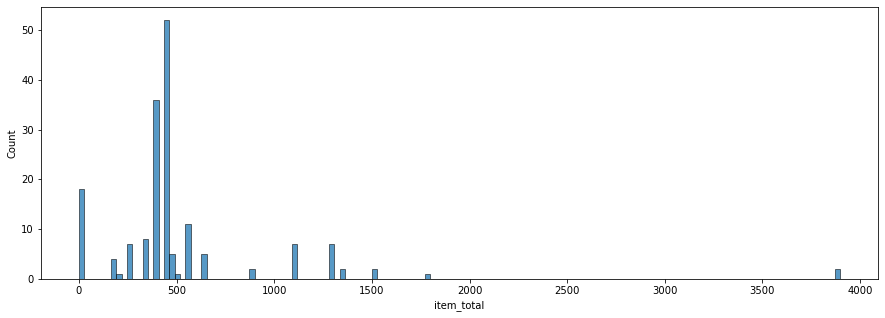

In [13]:
plt.figure(figsize=(15,5))
sns.histplot(df['item_total'])

<AxesSubplot:xlabel='quantity', ylabel='Count'>

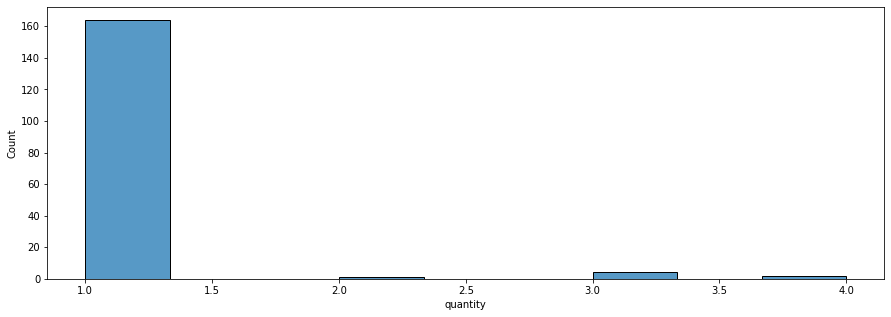

In [14]:
plt.figure(figsize=(15,5))
sns.histplot(df['quantity'])

<AxesSubplot:xlabel='shipping_fee', ylabel='Count'>

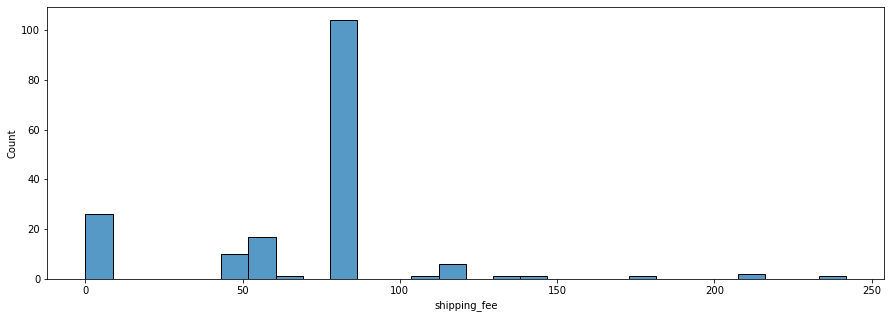

In [15]:
plt.figure(figsize=(15,5))
sns.histplot(df['shipping_fee'])

# 5. Visualizar insights do negócios

### Lucro por ano

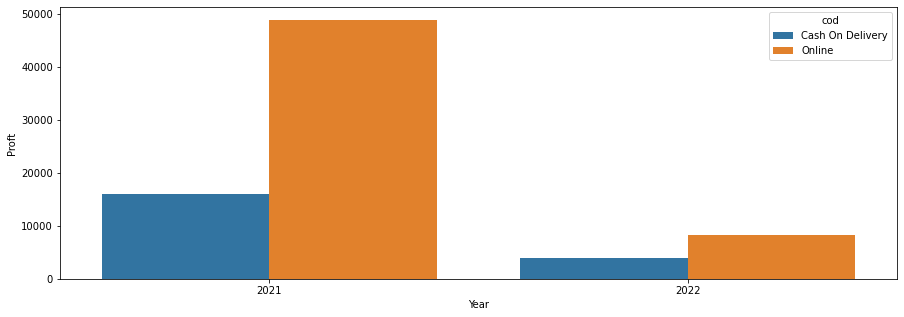

In [16]:
fig = df[['Year', 'cod', 'item_total', 'shipping_fee']].groupby(['Year', 'cod']).sum()
fig['Proft'] = fig['item_total'] - fig['shipping_fee']
fig.reset_index(inplace= True)

plt.figure(figsize=(15,5))
figure = sns.barplot(y= fig['Proft'], x=fig['Year'], hue=fig['cod'])

### Lucro por todo o periodo

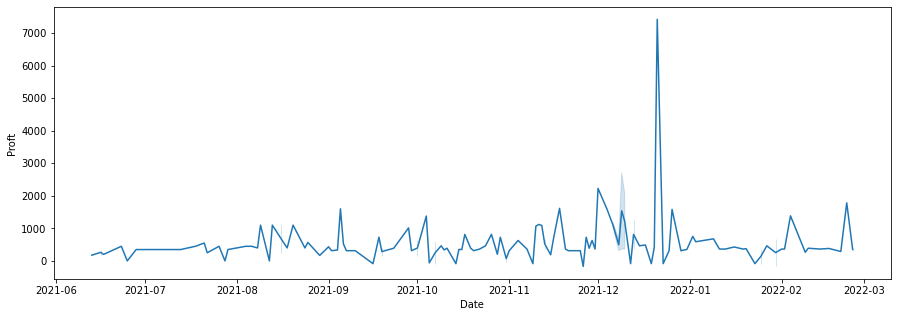

In [17]:
fig = df[['Date', 'cod', 'item_total', 'shipping_fee']].groupby(['Date', 'cod']).sum()
fig['Proft'] = fig['item_total'] - fig['shipping_fee']
fig.reset_index(inplace= True)

plt.figure(figsize=(15,5))
figure = sns.lineplot(y= fig['Proft'], x=fig['Date'])

### Lucro por mês

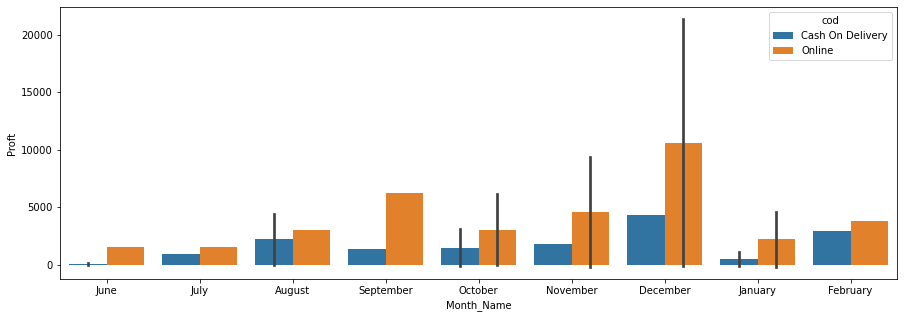

In [18]:
fig = df[['Month_Name', 'cod', 'order_status', 'item_total', 'shipping_fee']].groupby(['Month_Name', 'cod', 'order_status']).sum()
fig['Proft'] = fig['item_total'] - fig['shipping_fee']
fig.reset_index(inplace= True)

plt.figure(figsize=(15,5))
order = ['June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February']
figure = sns.barplot(data= fig, y= 'Proft', x='Month_Name', order= order, hue= 'cod')

### Analise dos Meses Dezembro e Janeiro

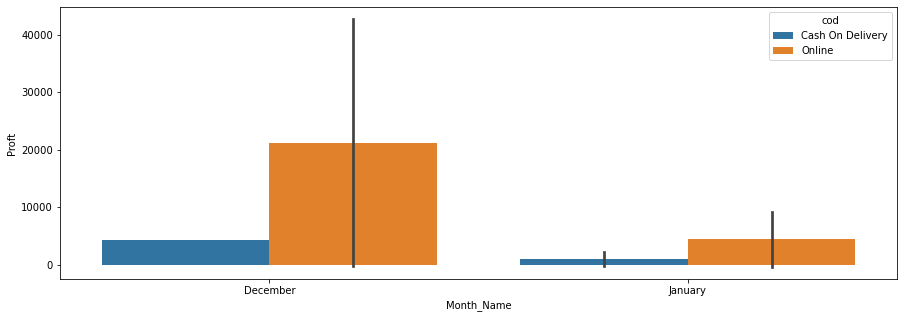

In [19]:
fig = df.query('Month_Name in ["December", "January"]').copy()
fig = fig[['Month_Name', 'cod', 'order_status', 'item_total', 'shipping_fee']].groupby(['Month_Name', 'cod', 'order_status']).sum()
fig['Proft'] = fig['item_total'] - fig['shipping_fee']
fig.reset_index(inplace= True)

plt.figure(figsize=(15,5))
order = ['December', 'January']
figure = sns.barplot(data= fig, y= 'Proft', x='Month_Name', order= order, hue= 'cod', estimator= np.sum)

### Analisando somente o mês de Dezembro

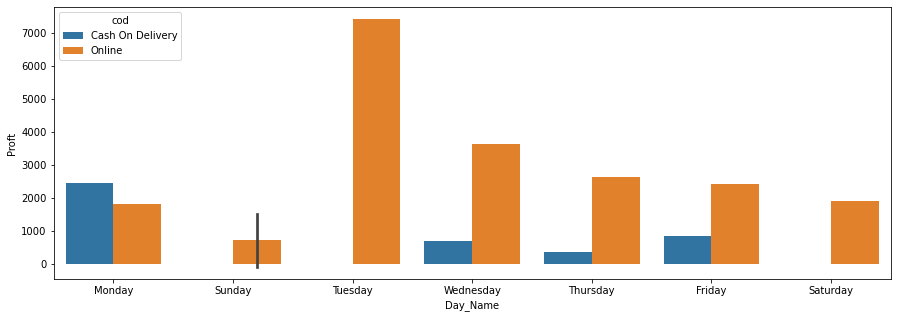

In [20]:
fig = df.query('Month_Name == "December"')
fig = fig[['Day_Name', 'cod', 'order_status', 'item_total', 'shipping_fee']].groupby(['Day_Name', 'cod', 'order_status']).sum()
fig['Proft'] = fig['item_total'] - fig['shipping_fee']
fig.reset_index(inplace= True)

plt.figure(figsize=(15,5))
order = ['Monday', 'Sunday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
figure = sns.barplot(data= fig, y= 'Proft', x='Day_Name', order= order, hue= 'cod')

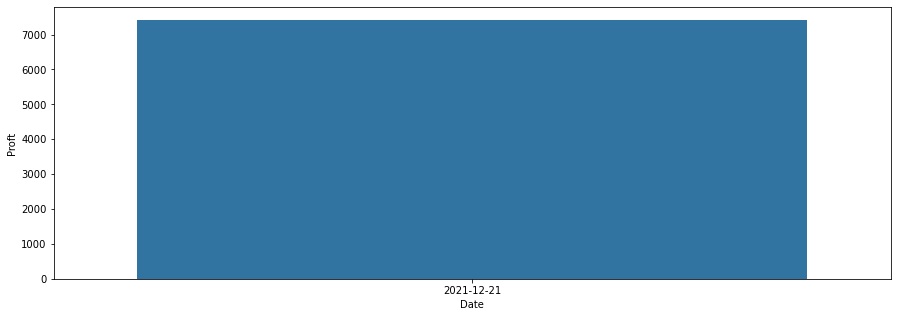

In [21]:
fig = df.query('Month_Name == "December" & Day_Name == "Tuesday"')
fig = fig[['Date', 'item_total', 'shipping_fee']].groupby(['Date']).sum()
fig['Proft'] = fig['item_total'] - fig['shipping_fee']
fig.reset_index(inplace= True)

plt.figure(figsize=(15,5))
figure = sns.barplot(data= fig, y= 'Proft', x='Date')

### Comparando custos de Devoluções nos meses de Dezembro e Janeiro

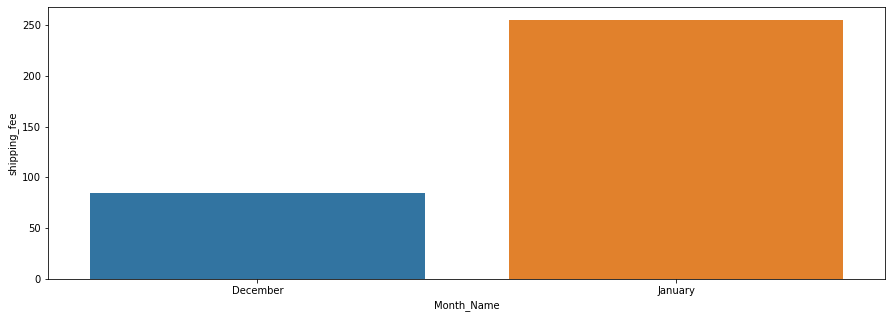

In [22]:
fig = df.query('Month_Name in ["December", "January"]').copy()
fig = fig[['Month_Name', 'order_status', 'shipping_fee']].groupby(['Month_Name', 'order_status']).sum()
fig.reset_index(inplace= True)
fig.query('order_status == "Returned to seller"', inplace= True)

plt.figure(figsize=(15,5))
order = ['December', 'January']
figure = sns.barplot(data= fig, y= 'shipping_fee', x='Month_Name', order= order)

### Analisando os lucros por dia da semana

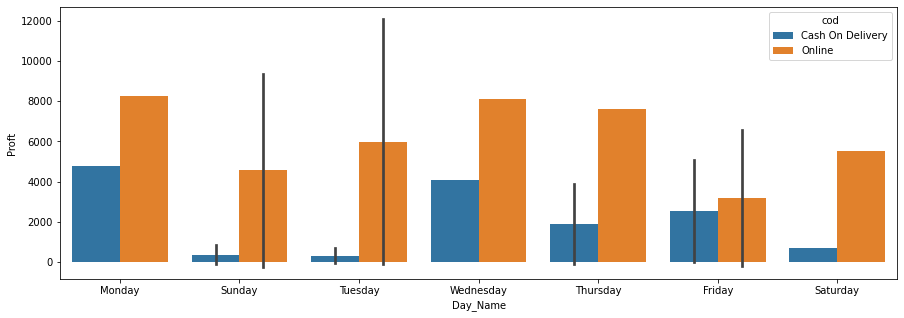

In [23]:
fig = df[['Day_Name', 'cod', 'order_status', 'item_total', 'shipping_fee']].groupby(['Day_Name', 'cod', 'order_status']).sum()
fig['Proft'] = fig['item_total'] - fig['shipping_fee']
fig.reset_index(inplace= True)

plt.figure(figsize=(15,5))
order = ['Monday', 'Sunday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
figure = sns.barplot(data= fig, y= 'Proft', x='Day_Name', order= order, hue= 'cod')

### Lucro por Estado

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

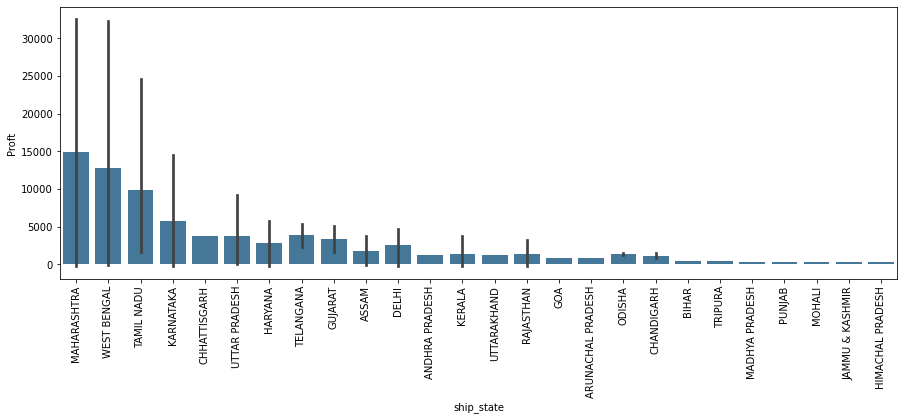

In [24]:
fig = df[['ship_state', 'cod', 'order_status', 'item_total', 'shipping_fee']].groupby(['ship_state', 'cod', 'order_status']).sum()
fig['Proft'] = fig['item_total'] - fig['shipping_fee']
fig.sort_values(by= 'Proft', ascending= False, inplace= True)
fig.reset_index(inplace= True)

plt.figure(figsize=(15,5))
figure = sns.barplot(data= fig, y= 'Proft', x='ship_state', color = "#377BA6", estimator= np.sum)
plt.xticks(rotation= 90)[0]

### Analise de cidades dos TOP 3 estados

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

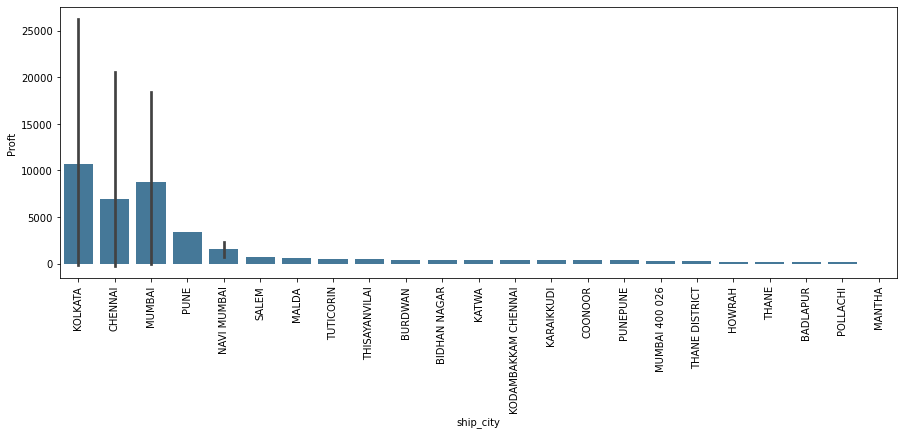

In [25]:
fig = df.query('ship_state in ["MAHARASHTRA", "WEST BENGAL", "TAMIL NADU"]')
fig = fig[['ship_city', 'cod', 'order_status', 'item_total', 'shipping_fee']].groupby(['ship_city', 'cod', 'order_status']).sum()
fig['Proft'] = fig['item_total'] - fig['shipping_fee']
fig.sort_values(by= 'Proft', ascending= False, inplace= True)
fig.reset_index(inplace= True)

plt.figure(figsize=(15,5))
figure = sns.barplot(data= fig, y= 'Proft', x='ship_city', color= '#377BA6', estimator= np.sum)
plt.xticks(rotation= 90)[0]

### Analise das Cidades do estado "MAHARASHTRA"

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

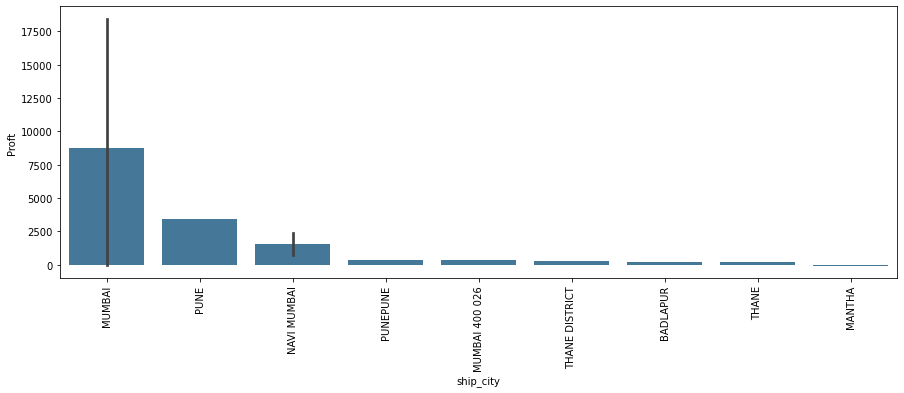

In [26]:
fig = df.query('ship_state  == "MAHARASHTRA"')
fig = fig[['ship_city', 'cod', 'order_status', 'item_total', 'shipping_fee']].groupby(['ship_city', 'cod', 'order_status']).sum()
fig['Proft'] = fig['item_total'] - fig['shipping_fee']
fig.sort_values(by= 'Proft', ascending= False, inplace= True)
fig.reset_index(inplace= True)

plt.figure(figsize=(15,5))
figure = sns.barplot(data= fig, y= 'Proft', x='ship_city', color= '#377BA6', estimator= np.sum)
plt.xticks(rotation= 90)[0]

### Analise das Cidades do estado "WEST BENGAL"

array([0, 1, 2, 3, 4, 5])

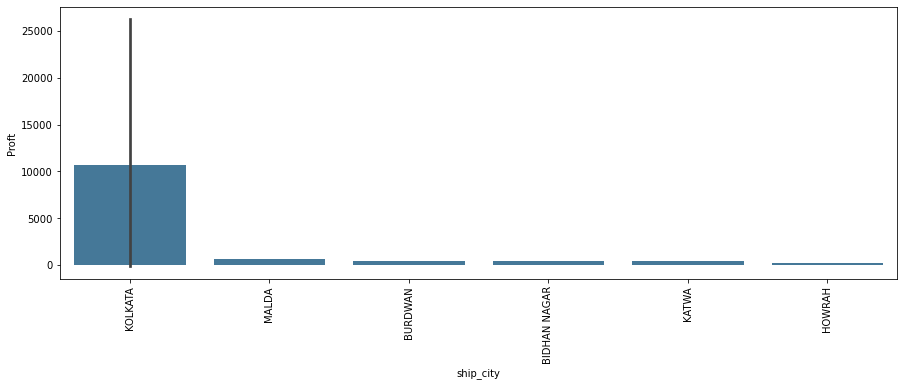

In [27]:
fig = df.query('ship_state  == "WEST BENGAL"')
fig = fig[['ship_city', 'cod', 'order_status', 'item_total', 'shipping_fee']].groupby(['ship_city', 'cod', 'order_status']).sum()
fig['Proft'] = fig['item_total'] - fig['shipping_fee']
fig.sort_values(by= 'Proft', ascending= False, inplace= True)
fig.reset_index(inplace= True)

plt.figure(figsize=(15,5))
figure = sns.barplot(data= fig, y= 'Proft', x='ship_city', color= '#377BA6', estimator= np.sum)
plt.xticks(rotation= 90)[0]

### Analise das Cidades do estado "TAMIL NADU"

array([0, 1, 2, 3, 4, 5, 6, 7])

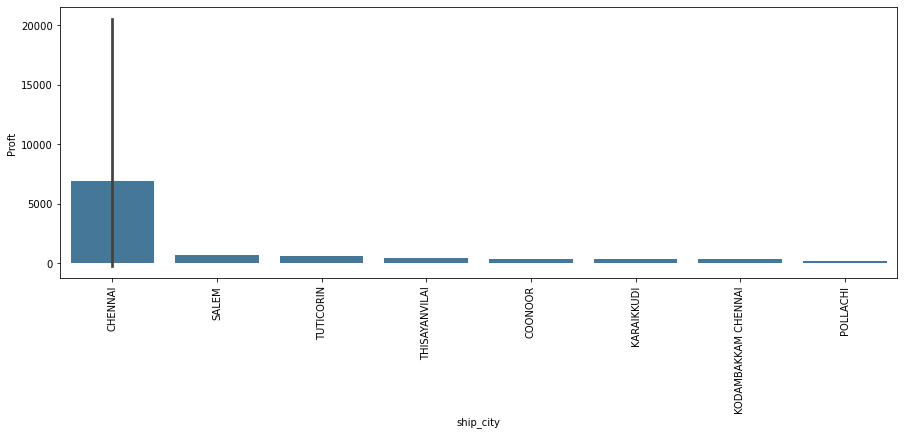

In [28]:
fig = df.query('ship_state  == "TAMIL NADU"')
fig = fig[['ship_city', 'cod', 'order_status', 'item_total', 'shipping_fee']].groupby(['ship_city', 'cod', 'order_status']).sum()
fig['Proft'] = fig['item_total'] - fig['shipping_fee']
fig.sort_values(by= 'Proft', ascending= False, inplace= True)
fig.reset_index(inplace= True)

plt.figure(figsize=(15,5))
figure = sns.barplot(data= fig, y= 'Proft', x='ship_city', color= '#377BA6', estimator= np.sum)
plt.xticks(rotation= 90)[0]

### Top 5 Produtos

array([0, 1, 2, 3, 4])

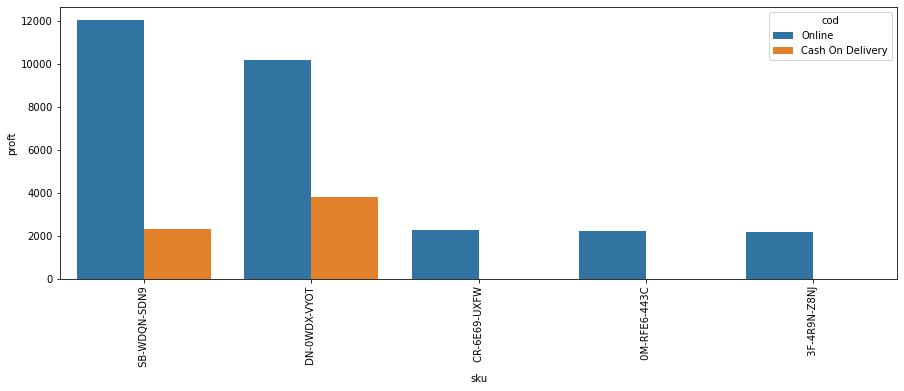

In [29]:
fig = df[['sku', 'cod', 'order_status', 'item_total', 'shipping_fee']].groupby(['sku', 'cod', 'order_status']).sum()
fig['proft'] = fig['item_total'] - fig['shipping_fee']
fig.sort_values(by= 'proft', ascending= False, inplace= True)
fig.reset_index(inplace= True)
fig = fig.iloc[:7]

plt.figure(figsize=(15,5))
figure = sns.barplot(data= fig, y= 'proft', x='sku', hue= 'cod')
plt.xticks(rotation= 90)[0]

# 6. Resumo dos insights

Limitaremos a 10 insights, mas podemos tirar muita mais que 10 insights.

1.	O lucro de 2021 foi maior que 2022, não porque 2021 foi mais performático, mas sim porque o range dos dados é de junho/2021 a fev/2022;
2.	Os compradores preferem pagar mais online do que na entrega;
3.	O mês de dezembro foi o que mais se destacou, provavelmente, devido ao Natal;
4.	Em dezembro, o dia da semana que teve mais venda foi a terça-feira e o dia 21/12/2021. Esse destaque ocorreu devido o natal;
5.	Observamos que em janeiro/2022 houve muita devoluções, o que demonstra o efeito do “arrependimento da compra” ;
6.	O estado que teve mais lucro foi o MAHARASHTRA seguido por WEST BENGAL e TAMIL NADU;
7.	A cidade que mais teve lucro em MAHARASHTRA foi Mumbai, com um lucro aproximado de 17,5k. Oque compõem 60% do lucro do estado;
8.	A cidade que mais teve lucro em WEST BENGAL foi Kolkata, com um lucro aproximado de 25k. Oque compõem 85% do lucro do estado;
9.	A cidade que mais teve lucro em TAMIL NADU foi Chennai, com um lucro aproximado de 20k. Oque compõem 80% do lucro do estado;
10.	O produto que teve mais performasse foi o SKU: SB-WDQN-SDN9, com um lucro aproximadamente 120k em pagamentos online e 2k em pagamentos na entrega, já o produto SKU: DN-0WDX-VYOT deve um lucro de 4k em pagamentos na entrega, comparado aos outros produtos.


# 7. Visualizando correlação dos dados

In [30]:
def normalization(df, N= 0):
    df = df.copy()
    
    # Removendo colunas desnecessarias
    df.drop(columns= ['order_no', 'Date', 'Time', 'Month_Name', 'description'], inplace= True)
    
    # Categorizando dados
    enconder = LabelEncoder()
    labels = ['buyer', 'ship_city', 'ship_state', 'sku', 'cod', 'order_status', 'Year', 'Day_Name']
    
    cat = df[labels].copy()
    
    for label in labels:
        cat[label] = enconder.fit_transform(cat[label])
        
    df.drop(columns= labels, inplace= True)
    df = pd.concat([df, cat], axis= 1)
    
    # Balanceando as classes
    seller = df.query('order_status == 1')
    buyer = df.query('order_status == 0').sample(n=len(seller)+N, random_state = 48)
    
    df = pd.concat([seller, buyer], axis= 0, ignore_index= True)
    
    # Normalizando Valores
    scaler = StandardScaler()
    
    X = df.drop(columns= 'order_status')
    y = df['order_status']
    
    df = pd.DataFrame(scaler.fit_transform(X), columns= X.columns)
    df = pd.concat([df, y], axis= 1)
    
    return df

In [31]:
new_df = normalization(df)
new_df.head()

,quantity,item_total,shipping_fee,Month,buyer,ship_city,ship_state,sku,cod,Year,Day_Name,order_status
0,-0.218218,-0.719673,-1.999423,0.221396,1.801799,0.943807,0.970757,1.364292,-1.20185,-0.68313,0.405567,1
1,-0.218218,-0.719673,0.646430,0.685274,0.687154,0.613350,-0.168265,1.974065,-1.20185,-0.68313,0.405567,1
2,-0.218218,-0.719673,0.646430,0.917213,-0.752597,-0.543253,-1.022531,-0.126266,0.83205,-0.68313,-1.693840,1
3,-0.218218,-0.719673,-1.999423,-0.242482,1.360585,0.668426,-0.168265,-1.345814,-1.20185,-0.68313,-1.693840,1
4,4.582576,-0.719673,0.646430,0.917213,-0.357827,0.833655,-1.449664,-1.074803,0.83205,-0.68313,-1.693840,1


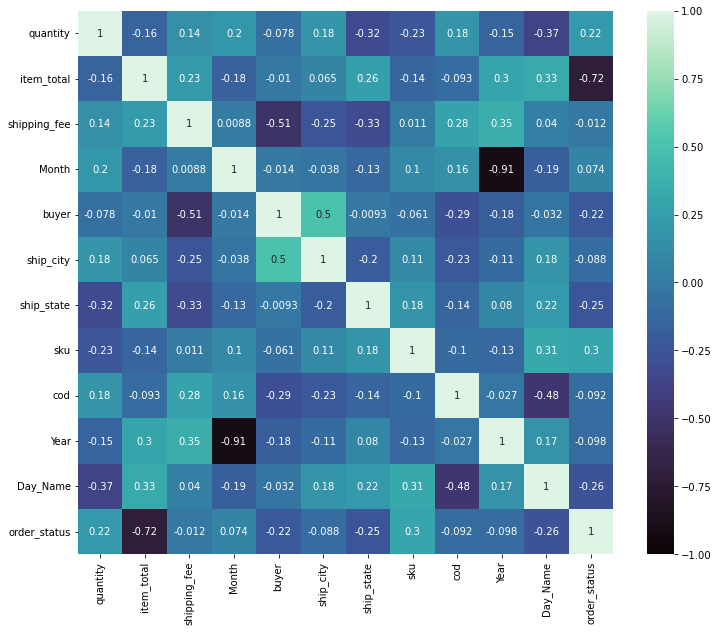

In [32]:
corr = new_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot= True, vmin= -1.0, cmap= 'mako')
plt.show()

# 8. Treinando modelos

In [33]:
def model(df, modelo, parametros):
    df= df.copy()
    
    # Removendo colunas desnecessarias
    df.drop(columns= ['order_no', 'Date', 'Time', 'Month_Name', 'description'], inplace= True)
    
    # Categorizando dados
    enconder = LabelEncoder()
    labels = ['buyer', 'ship_city', 'ship_state', 'sku', 'cod', 'order_status', 'Year', 'Day_Name']
    
    cat = df[labels].copy()
    
    for label in labels:
        cat[label] = enconder.fit_transform(cat[label])
        
    df.drop(columns= labels, inplace= True)
    df = pd.concat([df, cat], axis= 1)
    
    # Balanceando as classes
    seller = df.query('order_status == 1')
    buyer = df.query('order_status == 0').sample(n=len(seller)+10, random_state = 48)
    
    df_balanceado = pd.concat([seller, buyer], axis= 0, ignore_index= True)
    
    # Separando Dataset em X e y
    X_balanceado = df_balanceado.drop(columns= 'order_status').copy()
    y_balanceado = df_balanceado['order_status'].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X_balanceado, y_balanceado, test_size= .3, random_state=42)
    
    X_sub = df.drop(columns= 'order_status').copy()
    y_sub = df['order_status'].copy()
    
    # Normalizando Valores
    scaler = StandardScaler()
    
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns= X_train.columns)
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns= X_test.columns)
    X_sub = pd.DataFrame(scaler.fit_transform(X_sub), columns= X_test.columns)
    
    # Otimizando hiperparametros
    cv = GridSearchCV(modelo, param_grid= parametros, cv=10)
    cv.fit(X_train, y_train)
    
    # Selecionando o melhor modelo
    modelo = cv.best_estimator_

    return modelo, X_train, y_train, X_test, y_test, X_sub, y_sub

### KNN - Mark 1

In [34]:
params_knn = {
    'n_neighbors': [row for row in range(5, 50, 5)],
    'weights': ['uniform', 'distance'],
}

knn, X_train, y_train, X_test, y_test, X_sub, y_sub = model(df= df, modelo= KNeighborsClassifier(), parametros= params_knn)

### SVC - Mark 2

In [35]:
params_svc = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': [N for N in range(0, 110, 5)],
}

svc, X_train, y_train, X_test, y_test, X_sub, y_sub = model(df= df, modelo= LinearSVC(), parametros= params_svc)

### Decision Tree Classifier - Mark 3

In [36]:
params_decisiontree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [N for N in range(0, 100, 5)],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

decisionTree, X_train, y_train, X_test, y_test, X_sub, y_sub = model(df= df, modelo= DecisionTreeClassifier(), parametros= params_decisiontree)

### Logistic Regression - Mark 4

In [37]:
params_log = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [N for N in range(0, 110, 5)]
}

log, X_train, y_train, X_test, y_test, X_sub, y_sub = model(df= df, modelo= LogisticRegression(), parametros= params_log)

# 9. Avaliando modelos

In [38]:
def resume_metrics(modelo, X_train, y_train, X_test, y_test, X_sub, y_sub):
    
    # Prevendo dados de teste e dados de treino
    train_pred = modelo.predict(X_train)
    test_pred = modelo.predict(X_test)
    sub_pred = modelo.predict(X_sub)
    
    # Criando dataframe com o resumo das metricas
    metrics = {
        'Accuracy Score': [accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred), accuracy_score(y_sub, sub_pred)],
        'F1 Score': [f1_score(y_test, test_pred), f1_score(y_train, train_pred)],
        'Log Loss': [log_loss(y_test, test_pred), log_loss(y_train, train_pred)],
        'Precision Score': [precision_score(y_test, test_pred), precision_score(y_train, train_pred)],
        'Recall Score': [recall_score(y_test, test_pred), recall_score(y_train, train_pred)],
        'Brier Score Loss': [brier_score_loss(y_test, test_pred), brier_score_loss(y_train, train_pred)],
        'ROC AUC Score': [roc_auc_score(y_test, test_pred), roc_auc_score(y_train, train_pred)]
    }
    
    metrics = pd.DataFrame(metrics, index= ['Data test', 'Data train'])
    
    return metrics

In [39]:
def plot_roc_curve(modelo, X_test, y_test):
    
    prob = modelo.predict_proba(X_test)
    prob = prob[:, 1]
    
    fper, tper, thresholds = roc_curve(y_test, prob)
    
    plt.figure(figsize=(10, 5))
    plt.plot(fper, tper, color='#377BA6', label='ROC')
    plt.plot([0, 1], [0, 1], color='#D96B2B', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [40]:
def model_metrics(dic_model, X_test, y_test):
    acc = []
    
    for index, modelo in dic_model.items():
    
        # Prevendo dados de teste e dados de treino
        test_pred = modelo.predict(X_test)

        # Criando dataframe com o resumo das metricas
        metrics = {
            'Name Model': index,
            'Accuracy Score': [accuracy_score(y_test, test_pred)],
            'F1 Score': [f1_score(y_test, test_pred)],
            'Log Loss': [log_loss(y_test, test_pred)],
            'Precision Score': [precision_score(y_test, test_pred)],
            'Recall Score': [recall_score(y_test, test_pred)],
            'Brier Score Loss': [brier_score_loss(y_test, test_pred)],
            'ROC AUC Score': [roc_auc_score(y_test, test_pred)]
        }
        
        metrics = pd.DataFrame(metrics)
   
        acc.append(metrics)
    
    acc = pd.concat(acc, axis= 0, ignore_index= True).sort_values(by='Accuracy Score', ascending= False)
    
    return acc

In [41]:
def evaluating_cost(dic, X_test, y_test):
    resultado = []

    for index, modelo in dic.items():

        for i in range(10, 101, 10):

            i = i/100

            X = X_test.sample(frac= i, random_state= 2)
            y = y_test[X.index]

            cm = confusion_matrix(y, modelo.predict(X))

            FN = cm[0][1]
            FP = cm[1][0]
            VN = cm[1][1]

            proft = (-FN * 10) + (-FP * 71.86) + (VN * 61.86) 

            resultado.append({'modelo': index, 'frac': i, 'proft': proft})
    
    resultado = pd.DataFrame(resultado)
    
    plt.figure(figsize= (15, 5))
    sns.lineplot(x= resultado['frac'], y= resultado['proft'], hue= resultado['modelo'])
    plt.show

### Resumo das Metricas por modelo

#### KNN - Mark 1

In [42]:
resume_metrics(knn, X_train, y_train, X_test, y_test)

,Accuracy Score,F1 Score,Log Loss,Precision Score,Recall Score,Brier Score Loss,ROC AUC Score
Data test,0.700000,0.000000,10.361633,0.0,0.000,0.300000,0.5000
Data train,0.681818,0.222222,10.989611,1.0,0.125,0.318182,0.5625


In [43]:
pd.DataFrame(confusion_matrix(y_test, knn.predict(X_test)), columns= ['Positive', 'Negative'], index= ['Positive', 'Negative'])

,Positive,Negative
Positive,7,0
Negative,3,0


#### SVC - Mark 2

In [44]:
resume_metrics(svc, X_train, y_train, X_test, y_test)

,Accuracy Score,F1 Score,Log Loss,Precision Score,Recall Score,Brier Score Loss,ROC AUC Score
Data test,0.9,0.857143,3.453958e+00,0.75,1.0,0.1,0.928571
Data train,1.0,1.000000,9.992007e-16,1.00,1.0,0.0,1.000000


In [45]:
pd.DataFrame(confusion_matrix(y_test, svc.predict(X_test)), columns= ['Positive', 'Negative'], index= ['Positive', 'Negative'])

,Positive,Negative
Positive,6,1
Negative,0,3


#### Decision Tree Classifier - Mark 3

In [46]:
resume_metrics(decisionTree, X_train, y_train, X_test, y_test)

,Accuracy Score,F1 Score,Log Loss,Precision Score,Recall Score,Brier Score Loss,ROC AUC Score
Data test,0.9,0.857143,3.453958e+00,0.75,1.0,0.1,0.928571
Data train,1.0,1.000000,9.992007e-16,1.00,1.0,0.0,1.000000


In [47]:
pd.DataFrame(confusion_matrix(y_test, decisionTree.predict(X_test)), columns= ['Positive', 'Negative'], index= ['Positive', 'Negative'])

,Positive,Negative
Positive,6,1
Negative,0,3


#### Logistic Regression - Mark 4

In [48]:
resume_metrics(log, X_train, y_train, X_test, y_test)

,Accuracy Score,F1 Score,Log Loss,Precision Score,Recall Score,Brier Score Loss,ROC AUC Score
Data test,0.9,0.857143,3.453958e+00,0.75,1.0,0.1,0.928571
Data train,1.0,1.000000,9.992007e-16,1.00,1.0,0.0,1.000000


In [49]:
pd.DataFrame(confusion_matrix(y_test, log.predict(X_test)), columns= ['Positive', 'Negative'], index= ['Positive', 'Negative'])

,Positive,Negative
Positive,6,1
Negative,0,3


### Grafico ROC por modelo

#### KNN - Mark 1

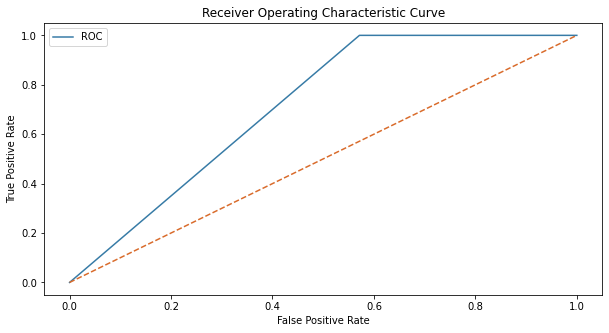

In [50]:
plot_roc_curve(knn, X_test, y_test)

#### Decision Tree Classifier - Mark 3

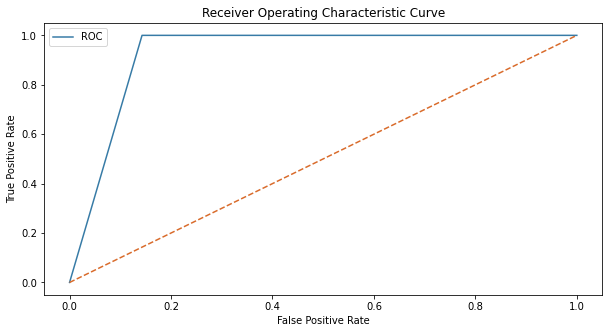

In [51]:
plot_roc_curve(decisionTree, X_test, y_test)

#### Logistic Regression - Mark 4

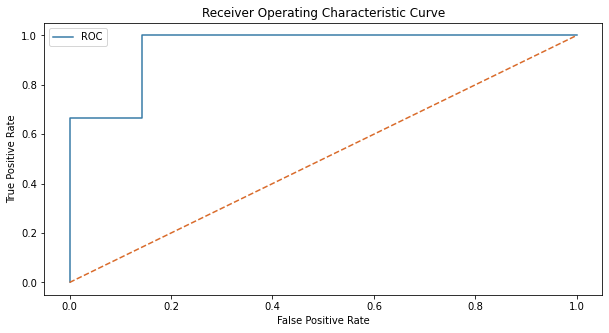

In [52]:
plot_roc_curve(log, X_test, y_test)

### Comparando Modelos

#### Comparando metricas

In [53]:
dic= {
    'Mark_1': knn,
    'Mark_2': svc,
    'Mark_3': decisionTree,
    'Mark_4': log
}

model_metrics(dic, X_test, y_test)

,Name Model,Accuracy Score,F1 Score,Log Loss,Precision Score,Recall Score,Brier Score Loss,ROC AUC Score
1,Mark_2,0.9,0.857143,3.453958,0.75,1.0,0.1,0.928571
2,Mark_3,0.9,0.857143,3.453958,0.75,1.0,0.1,0.928571
3,Mark_4,0.9,0.857143,3.453958,0.75,1.0,0.1,0.928571
0,Mark_1,0.7,0.000000,10.361633,0.00,0.0,0.3,0.500000


#### Comparando ganho monetario

In [54]:
evaluating_cost(dic, X_test, y_test)

KeyError: "None of [Int64Index([4], dtype='int64')] are in the [index]"

# 10. Resumo dos modelos

1.	Foi removido as colunas 'order_no', 'Date', 'Time', 'Month_Name' e 'description' pois elas se fazem desnecessárias para o treinamento do modelo;
2.	Foi categorizado e normalizado as colunas 'buyer', 'ship_city', 'ship_state', 'sku', 'cod', 'Year', 'Day_Name' e a coluna ‘order_status' so foi categorizada;
3.	Os dados foram balanceados, pois a proporção de “Delivered to buyer” é de 94% e “Returned to seller” é de 6%;
4.	Os dados foram balanceados em 21 registros para “Delivered to buyer” e 11 registros para “Returned to seller” (os únicos registros no dataset);
5.	Foi utilizado o GridSearchCV para otimização e validação de parâmetros;
6.	Na avaliação dos modelos, foi procurado o modelo que tivesse maior “Recall Score” e “ROC AUC Score”;
7.	Modelo que saiu com melhor acurácia (97,66%) foi o Mark 1 (knn), mas foi o modelo que teve o pior “Recall Score” (81,81%);
8.	Todos os outros modelos tiveram o “Recall Score” de 100%, mas o modelo que teve o maior “ROC AUC Score” foi o Mark 3 (Decision Tree Classifier), com 97,19%;
0. Para a simulação economica, para os gastos referente a devolução foi utilizado a media de gastos de entrega, um valor de 71.86, e para fixação (incentivo, brindes ou contato) foi definido o valor de 10 pontos monetarios;
9.	O modelo que trouxe maior ganho monetário foi o Mark 3 (Decision Tree Classifier), trazendo um ganho de 600 pontos monetários.
